# ML Challenge - Artificial Intelligence ThomasMore
- Alex van Poppel
- Tijs Kanters
- Vince Bruyndoncx



##### **Introduction**
This document outlines the process of analyzing and predicting a persons placement outcomes and salaries using machine learning. It includes:

1. **Data Cleaning & Encoding**: Preprocessing the dataset to handle missing values, encode categorical variables, and clean anomalies like invalid salary values.
2. **Exploratory Data Analysis (EDA)**: Identifying key predictors through visualizations and statistical analysis.
3. **Model Development**: Building models like Random Forest and Logistic Regression for placement prediction, and Random Forest Regressor for salary prediction.
4. **Model Evaluation**: Assessing models using metrics like accuracy, classification reports, and regression scores.
5. **Conclusion**: Summarizing insights into placement and salary prediction, highlighting improvements through feature selection and optimization.

Note. Running this notebook may take a few minutes depending on your system's specifications.

### Installing dependencies / Intitializing cleaned Dataset

In [1]:
!pip install pandas
!pip install numpy
!pip install matplotlib
!pip install seaborn
!pip install scikit-learn
!pip install scipy
!pip install optuna


[notice] A new release of pip is available: 24.3.1 -> 25.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip



[notice] A new release of pip is available: 24.3.1 -> 25.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip



[notice] A new release of pip is available: 24.3.1 -> 25.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip



[notice] A new release of pip is available: 24.3.1 -> 25.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip



[notice] A new release of pip is available: 24.3.1 -> 25.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip



[notice] A new release of pip is available: 24.3.1 -> 25.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip



[notice] A new release of pip is available: 24.3.1 -> 25.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


## Data Cleaning & Encoding

### Intitialization

In [2]:
# Importing the libraries that will be used from the point onwards
import pandas as pd
import numpy as np

# Load the dataset
train_path = 'DataSets/train_campusrecruit.csv'
train_df = pd.read_csv(train_path)

df = pd.DataFrame(train_df)

### Cleaning / Encoding

Invalid salary values (`salary == 0.0`) for placed students are replaced with `NaN` and then filled with the median salary to prevent skewing analysis. \
Rows with any missing values are dropped to ensure clean data for modeling. Categorical columns like `gender`, `status`, and `workex` are mapped to binary values for easier processing in our machine leaning models. Other categorical features are one-hot encoded to avoid issues with non-numeric data. The final cleaned dataset is saved for further use.

In [3]:
# Set all placed salaries that are 0.0 to the median
if 'salary' in train_df.columns:
    train_df.loc[(train_df['status'] == 'Placed') & (train_df['salary'] == 0.0), 'salary'] = float('nan')
    train_df.loc[:, 'salary'] = train_df['salary'].fillna(train_df['salary'].median())


# Drop rows with null values
df.dropna(inplace=True)

# Encode categorical columns
df['gender'] = df['gender'].map({'M': 1, 'F': 0})
df['status'] = df['status'].map({'Placed': 1, 'Not Placed': 0})
df['workex'] = df['workex'].map({'Yes': 1, 'No': 0})
df = pd.get_dummies(df, columns=["ssc_b", "hsc_b", "hsc_s", "degree_t", "specialisation"], drop_first=True)

df.to_csv('./Cleaned/EncodedDataSet.csv', index=False)

df.head()

id  gender  ssc_p  hsc_p  degree_p  workex  etest_p  mba_p  status  \
0   61       1  61.84  57.93     68.03       0    60.60  55.10       0   
1  273       1  63.06  75.61     63.40       1    62.33  54.69       1   
2  489       1  76.34  63.37     71.33       0    53.98  53.03       1   
3  721       1  54.12  65.47     73.83       1    62.09  58.87       0   
4   95       1  63.12  68.94     66.08       1    71.99  67.01       1   

     salary  ssc_b_Others  hsc_b_Others  hsc_s_Commerce  hsc_s_Science  \
0       0.0          True          True           False           True   
1  424507.0         False         False            True          False   
2  200000.0         False         False           False           True   
3       0.0          True          True            True          False   
4  327148.0          True         False            True          False   

   degree_t_Others  degree_t_Sci&Tech  specialisation_Mkt&HR  
0            False               True                   True  
1            False              False                   True  
2            False               True                   True  
3            False              False                  False  
4            False              False                   True

## Exploratory Data Analysis (EDA)

### Intitialization

Essential libraries for data visualization (`matplotlib`, `seaborn`), machine learning (`RandomForestClassifier`, `accuracy_score`, etc.), and statistical analysis (`entropy`, `gaussian_kde`) are imported. \
The dataset is loaded from a CSV file and converted into a DataFrame. Since the `salary` column isn't present in the test dataset, it's dropped from the training data to ensure consistency between training and testing datasets.

In [4]:
# Importing the libraries that will be used from the point onwards
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.model_selection import cross_val_score, train_test_split, GridSearchCV
from scipy.stats import entropy, gaussian_kde

# Load the dataset
train_path = 'Cleaned/EncodedDataSet.csv'
train_df = pd.read_csv(train_path)

df = pd.DataFrame(train_df)

# Dropping salary since its not in in the test dataset
df = df.drop(columns=['salary'], errors='ignore')


### Placed vs Not placed - Data Bias

In our dataset, with 177 "not placed" records and 523 "placed" records, the imbalance can introduce bias in the model. The model may favor the majority class ("placed") due to seeing more examples, leading to:

1. **Class Imbalance**: The model might predict "placed" more often, neglecting the "not placed" class.
2. **Underperformance**: The model may struggle to accurately predict "not placed" outcomes, resulting in misclassification.


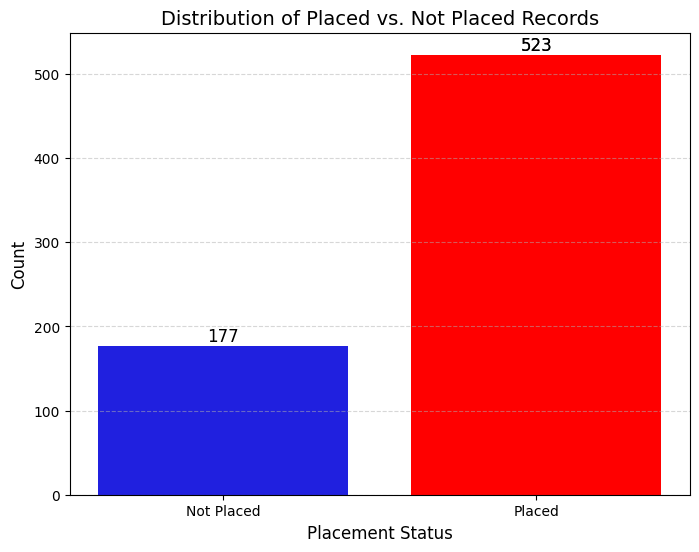

In [5]:
# Create a copy of the original dataset
df_copy = df.copy()

# Map status to readable labels in the copied dataset
df_copy["status"] = df_copy["status"].map({1: "Placed", 0: "Not Placed"})

# Plot the distribution of Placed vs Not Placed with custom colors
plt.figure(figsize=(8, 6))
sns.countplot(x="status", data=df_copy, color="blue")  # Set color for Not Placed

# Highlight "Placed" records in red
plt.bar("Placed", df_copy[df_copy["status"] == "Placed"].shape[0], color="red")

# Adding counts on top of bars
for p in plt.gca().patches:
    height = p.get_height()
    x = p.get_x() + p.get_width() / 2  # Get the x position of the bar
    plt.text(x, height + 0.05, str(int(height)), ha="center", va="bottom", fontsize=12)

plt.title("Distribution of Placed vs. Not Placed Records", fontsize=14)
plt.xlabel("Placement Status", fontsize=12)
plt.ylabel("Count", fontsize=12)
plt.grid(axis="y", linestyle="--", alpha=0.5)

plt.show()


### Placement vs Columns Correlation

The correlation matrix is calculated to assess how each feature relates to the `status` (placement). Features with higher correlation coefficients, whether positive or negative, are likely to be more influential in predicting placement. \
Features with correlations near 0, however, suggest little to no relationship with placement status and might not be strong predictors. \
By visualizing this in a bar chart, we can easily spot key predictors to prioritize, while identifying weaker features that could potentially be dropped for model efficiency. \
\
With this, we can infer that columns such as mba_p, degree_t_Sci&Tech, ssc_b_Others, and potentially others with near-zero correlation are unlikely to contribute to the model and may improve its performance if dropped entirely.

status                   1.000000
ssc_p                    0.352809
degree_p                 0.315121
hsc_p                    0.260015
etest_p                  0.066275
hsc_s_Commerce           0.037026
workex                   0.018613
mba_p                    0.004016
degree_t_Sci&Tech        0.001450
ssc_b_Others            -0.009005
id                      -0.014672
hsc_s_Science           -0.020013
specialisation_Mkt&HR   -0.028849
degree_t_Others         -0.043112
gender                  -0.048660
hsc_b_Others            -0.058612
Name: status, dtype: float64


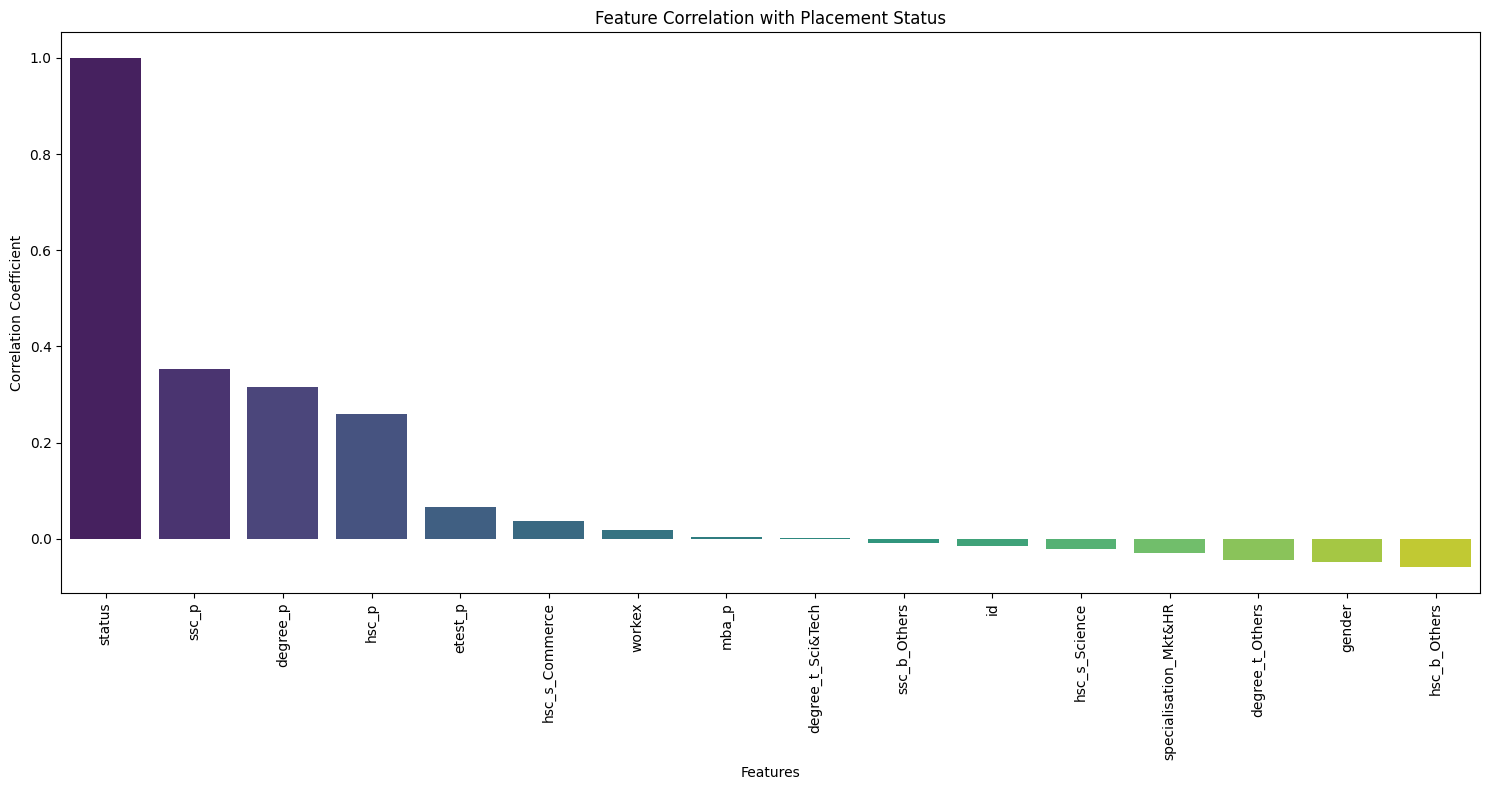

In [6]:
# Correlation matrix
correlation_matrix = df.corr()["status"].sort_values(ascending=False)
print(correlation_matrix)

# Plotting the correlation with 'status' as a bar chart
plt.figure(figsize=(15, 8))
sns.barplot(x=correlation_matrix.index, y=correlation_matrix.values, palette="viridis", hue=correlation_matrix.index,)
plt.title("Feature Correlation with Placement Status")
plt.ylabel("Correlation Coefficient")
plt.xlabel("Features")
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()


### Categorical Occurrence: Placed vs Not Placed

The categorical features, including `gender`, `workex`, and others, were analyzed to examine their distribution in both the placed and not-placed groups. \
The bar plots visualize these occurrences, with the percentage lines representing the proportion of each category within its respective column. For example, 72.3% of the total records in the dataset in the `gender` column represent males. \
Features with large differences in occurrence or percentage might be stronger indicators of placement likelihood.

In [7]:
# Calculations / setup for next few graphs
# Identify categorical columns
categorical_cols = ['gender', 'workex'] + [col for col in df.columns if col.startswith(('ssc_b_', 'hsc_b_', 'hsc_s_', 'degree_t_', 'specialisation_'))]

# Co-occurrence matrix for dataframe
def co_occurrence(df, cols):
    return pd.DataFrame({col1: [(df[col1] & df[col2]).sum() for col2 in cols] for col1 in cols}, index=cols)

# Split dataset
placed_df, not_placed_df = df[df['status'] == 1], df[df['status'] == 0]

# Get Co-occurrence matrices
placed_co = co_occurrence(placed_df, categorical_cols)
not_placed_co = co_occurrence(not_placed_df, categorical_cols)

# Percentage difference matrix
# "+ 1e-6" to avoid division by zero --> causing error
percentage_diff = ((placed_co - not_placed_co) / (placed_co + not_placed_co + 1e-6)) * 100

# Calculate occurrences
placed_count, not_placed_count = placed_df[categorical_cols].sum(), not_placed_df[categorical_cols].sum()

# Function to plot bar graphs with percentage
def plot_occurrences(ax, counts, total, title, color):
    percentage = (counts / total) * 100
    ax.bar(counts.index, counts.values, color=color)
    ax.set_title(title)
    ax.set_xlabel("Categorical Features")
    ax.set_ylabel("Occurrences")
    ax.tick_params(axis="x", rotation=90)

    ax2 = ax.twinx()
    ax2.plot(counts.index, percentage, color='grey', marker='o', linestyle='--')
    ax2.set_ylabel("Percentage (%)")
    ax2.set_ylim(0, 100)

    for i, val in enumerate(percentage):
        ax2.annotate(f"{val:.1f}%", (counts.index[i], val), textcoords="offset points", xytext=(0, 5), ha='center', color='grey')


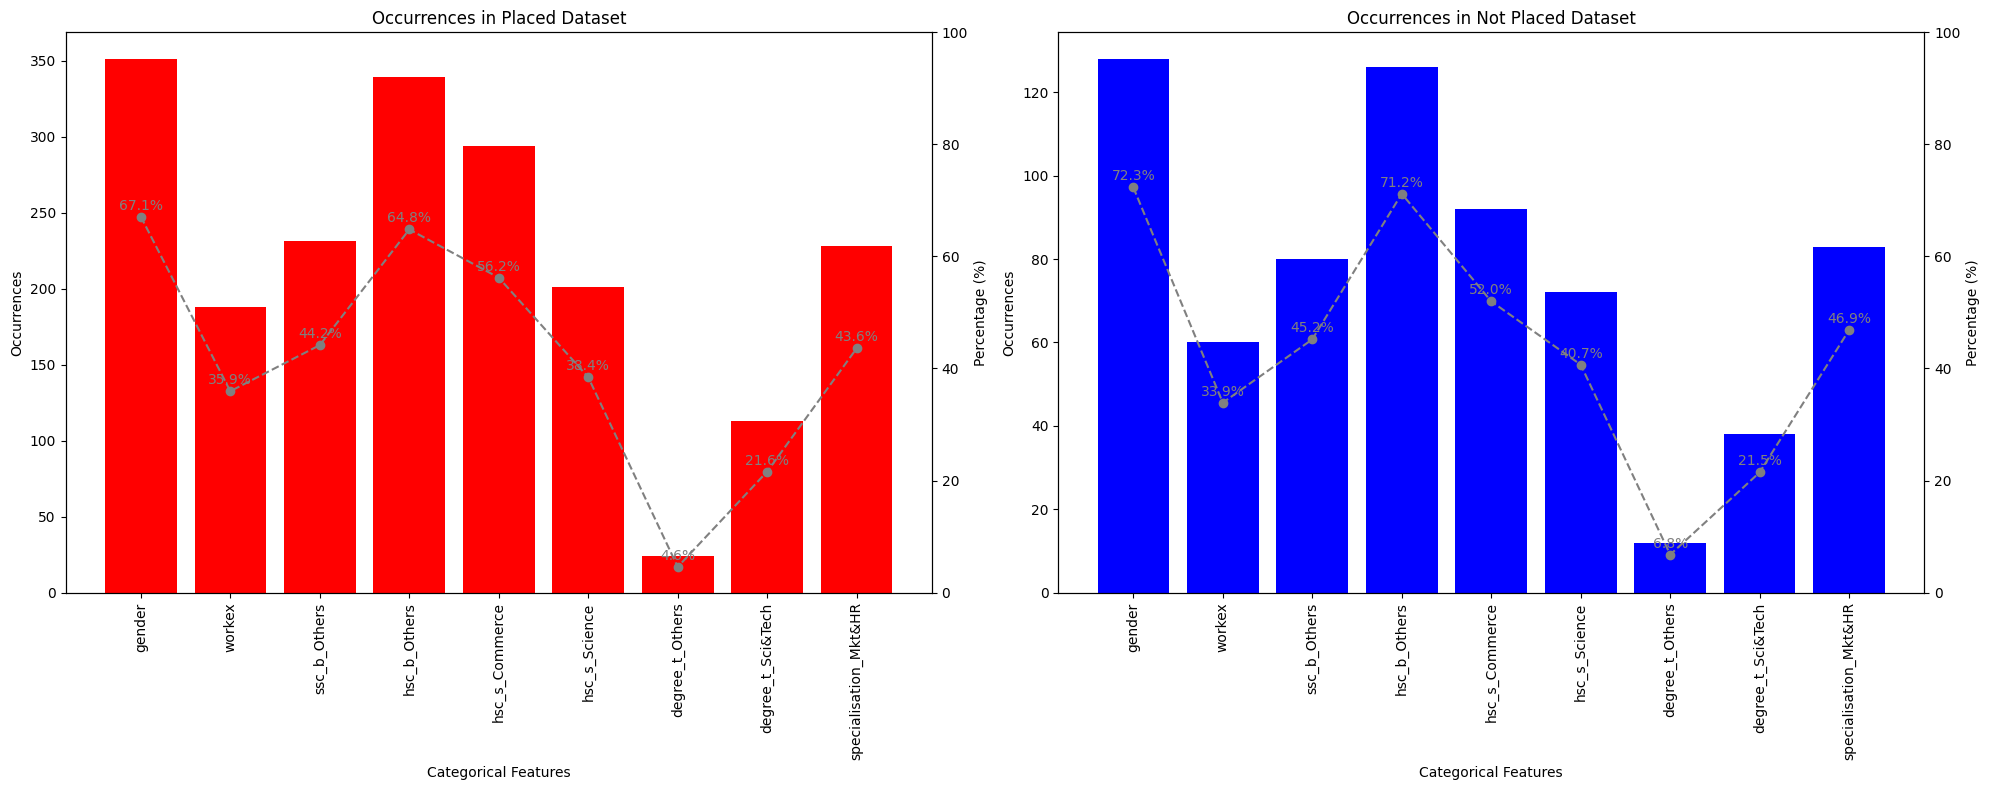

In [8]:
# Plot occurrences using function
fig, axes = plt.subplots(1, 2, figsize=(20, 8))
plot_occurrences(axes[0], placed_count, len(placed_df), "Occurrences in Placed Dataset", 'red')
plot_occurrences(axes[1], not_placed_count, len(not_placed_df), "Occurrences in Not Placed Dataset", 'blue')
plt.tight_layout()
plt.show()


### Categorical Occurrence Differential

By comparing the relative frequency of each feature in both groups, the plot highlights which features are more common in one group versus the other.  
Features with larger positive or negative differences may be stronger indicators of placement status, while values near zero suggest little distinction between the two groups. This visualization helps identify the most influential categorical features for predicting placement outcomes.  

This suggests that columns such as `workex`, `ssc_b_Others`, `degree_t_Sci&Tech` which all have a difference of ≤ 2%, might be worth removing to improve the model's efficiency and performance.

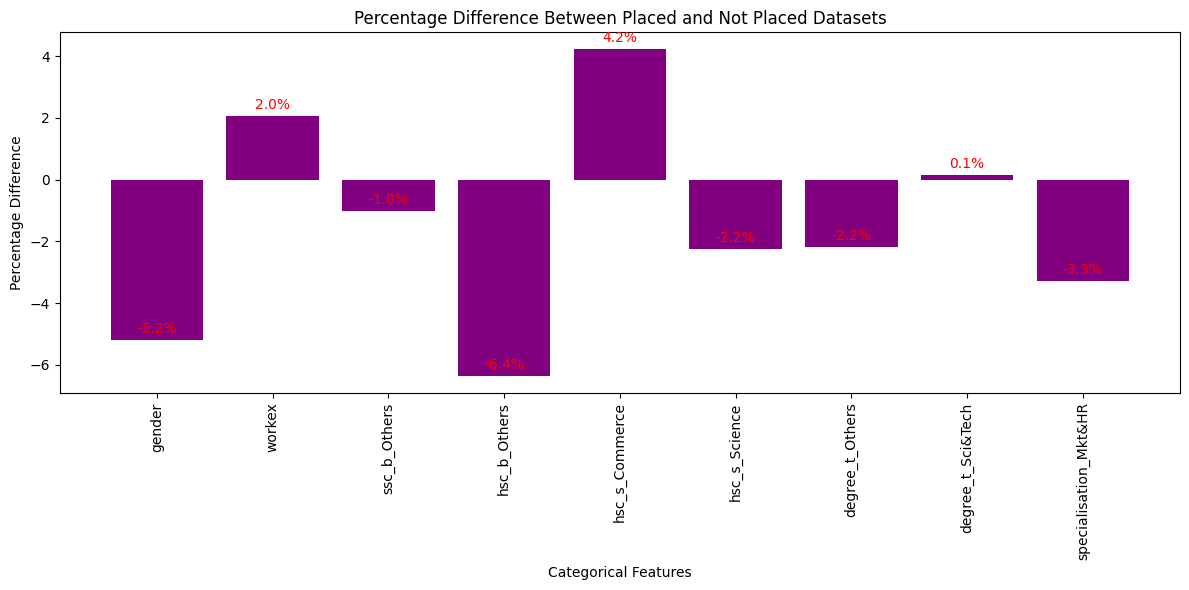

In [9]:
# Percentage difference plot
percentage_diff_values = (placed_count / len(placed_df) - not_placed_count / len(not_placed_df)) * 100
fig, ax = plt.subplots(figsize=(12, 6))
ax.bar(categorical_cols, percentage_diff_values, color='purple')
ax.set_title("Percentage Difference Between Placed and Not Placed Datasets")
ax.set_xlabel("Categorical Features")
ax.set_ylabel("Percentage Difference")
ax.tick_params(axis="x", rotation=90)

for i, val in enumerate(percentage_diff_values):
    ax.annotate(f"{val:.1f}%", (categorical_cols[i], val), textcoords="offset points", xytext=(0, 5), ha='center', color='red')

plt.tight_layout()
plt.show()

### Numerical Data Spread

This section analyzes the numerical features to understand how their distributions differ between placed and not-placed groups. 

1. **Boxplots for Comparison**  
   Boxplots are generated for each numerical feature, comparing their distributions across placement status. This helps identify differences in central tendency (median), spread (interquartile range), and outliers. Features with significant differences between the groups may be strong predictors of placement. 

2. **Frequency and Density Plots with KL-Divergence**  
   - **Frequency Plots**: Show how often each numerical value appears for placed and not-placed groups.  
   - **Density Plots**: Display the probability distribution of numerical features for both groups.  
   - **KL-Divergence Calculation**: Measures how different the distributions are between the two groups. Higher KL values indicate a greater distinction and suggest the feature is more informative for predicting placement. 

These visualizations and metrics help identify which numerical features have meaningful differences between placed and not-placed students, guiding feature selection for model improvement.

Based on the boxplot overlap and extremely low KL scores, we can conclude that columns such as `etest_p` and `mba_p`, which show little to no separation between the two groups, may be worth removing to improve the model's performance.

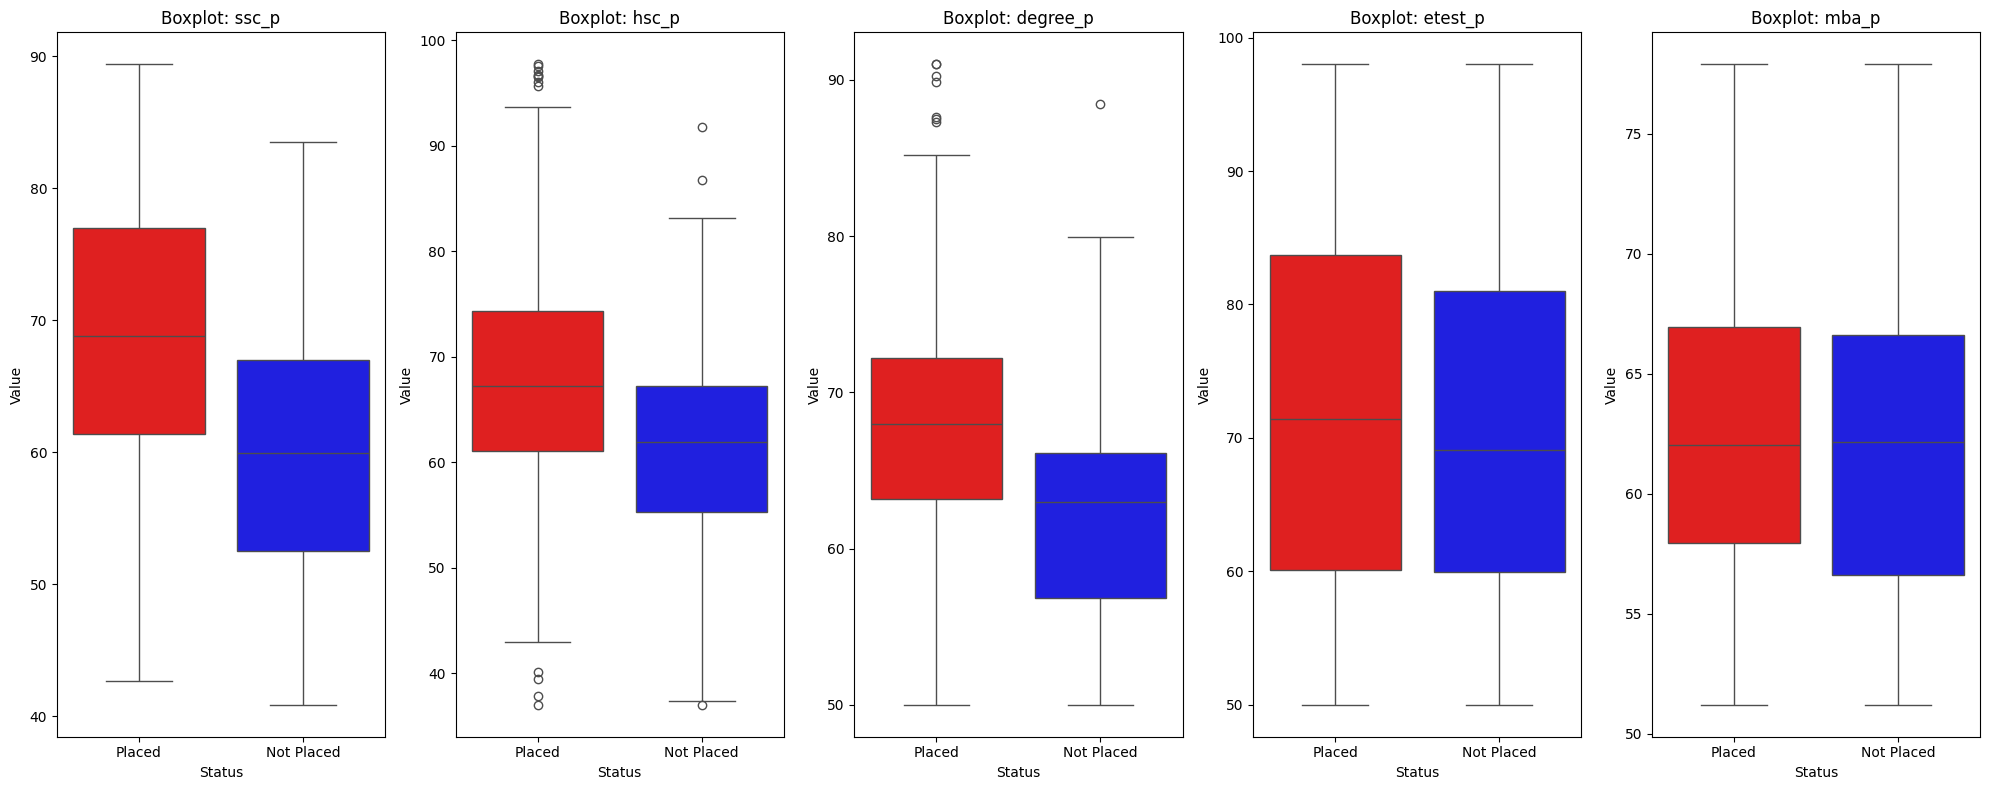

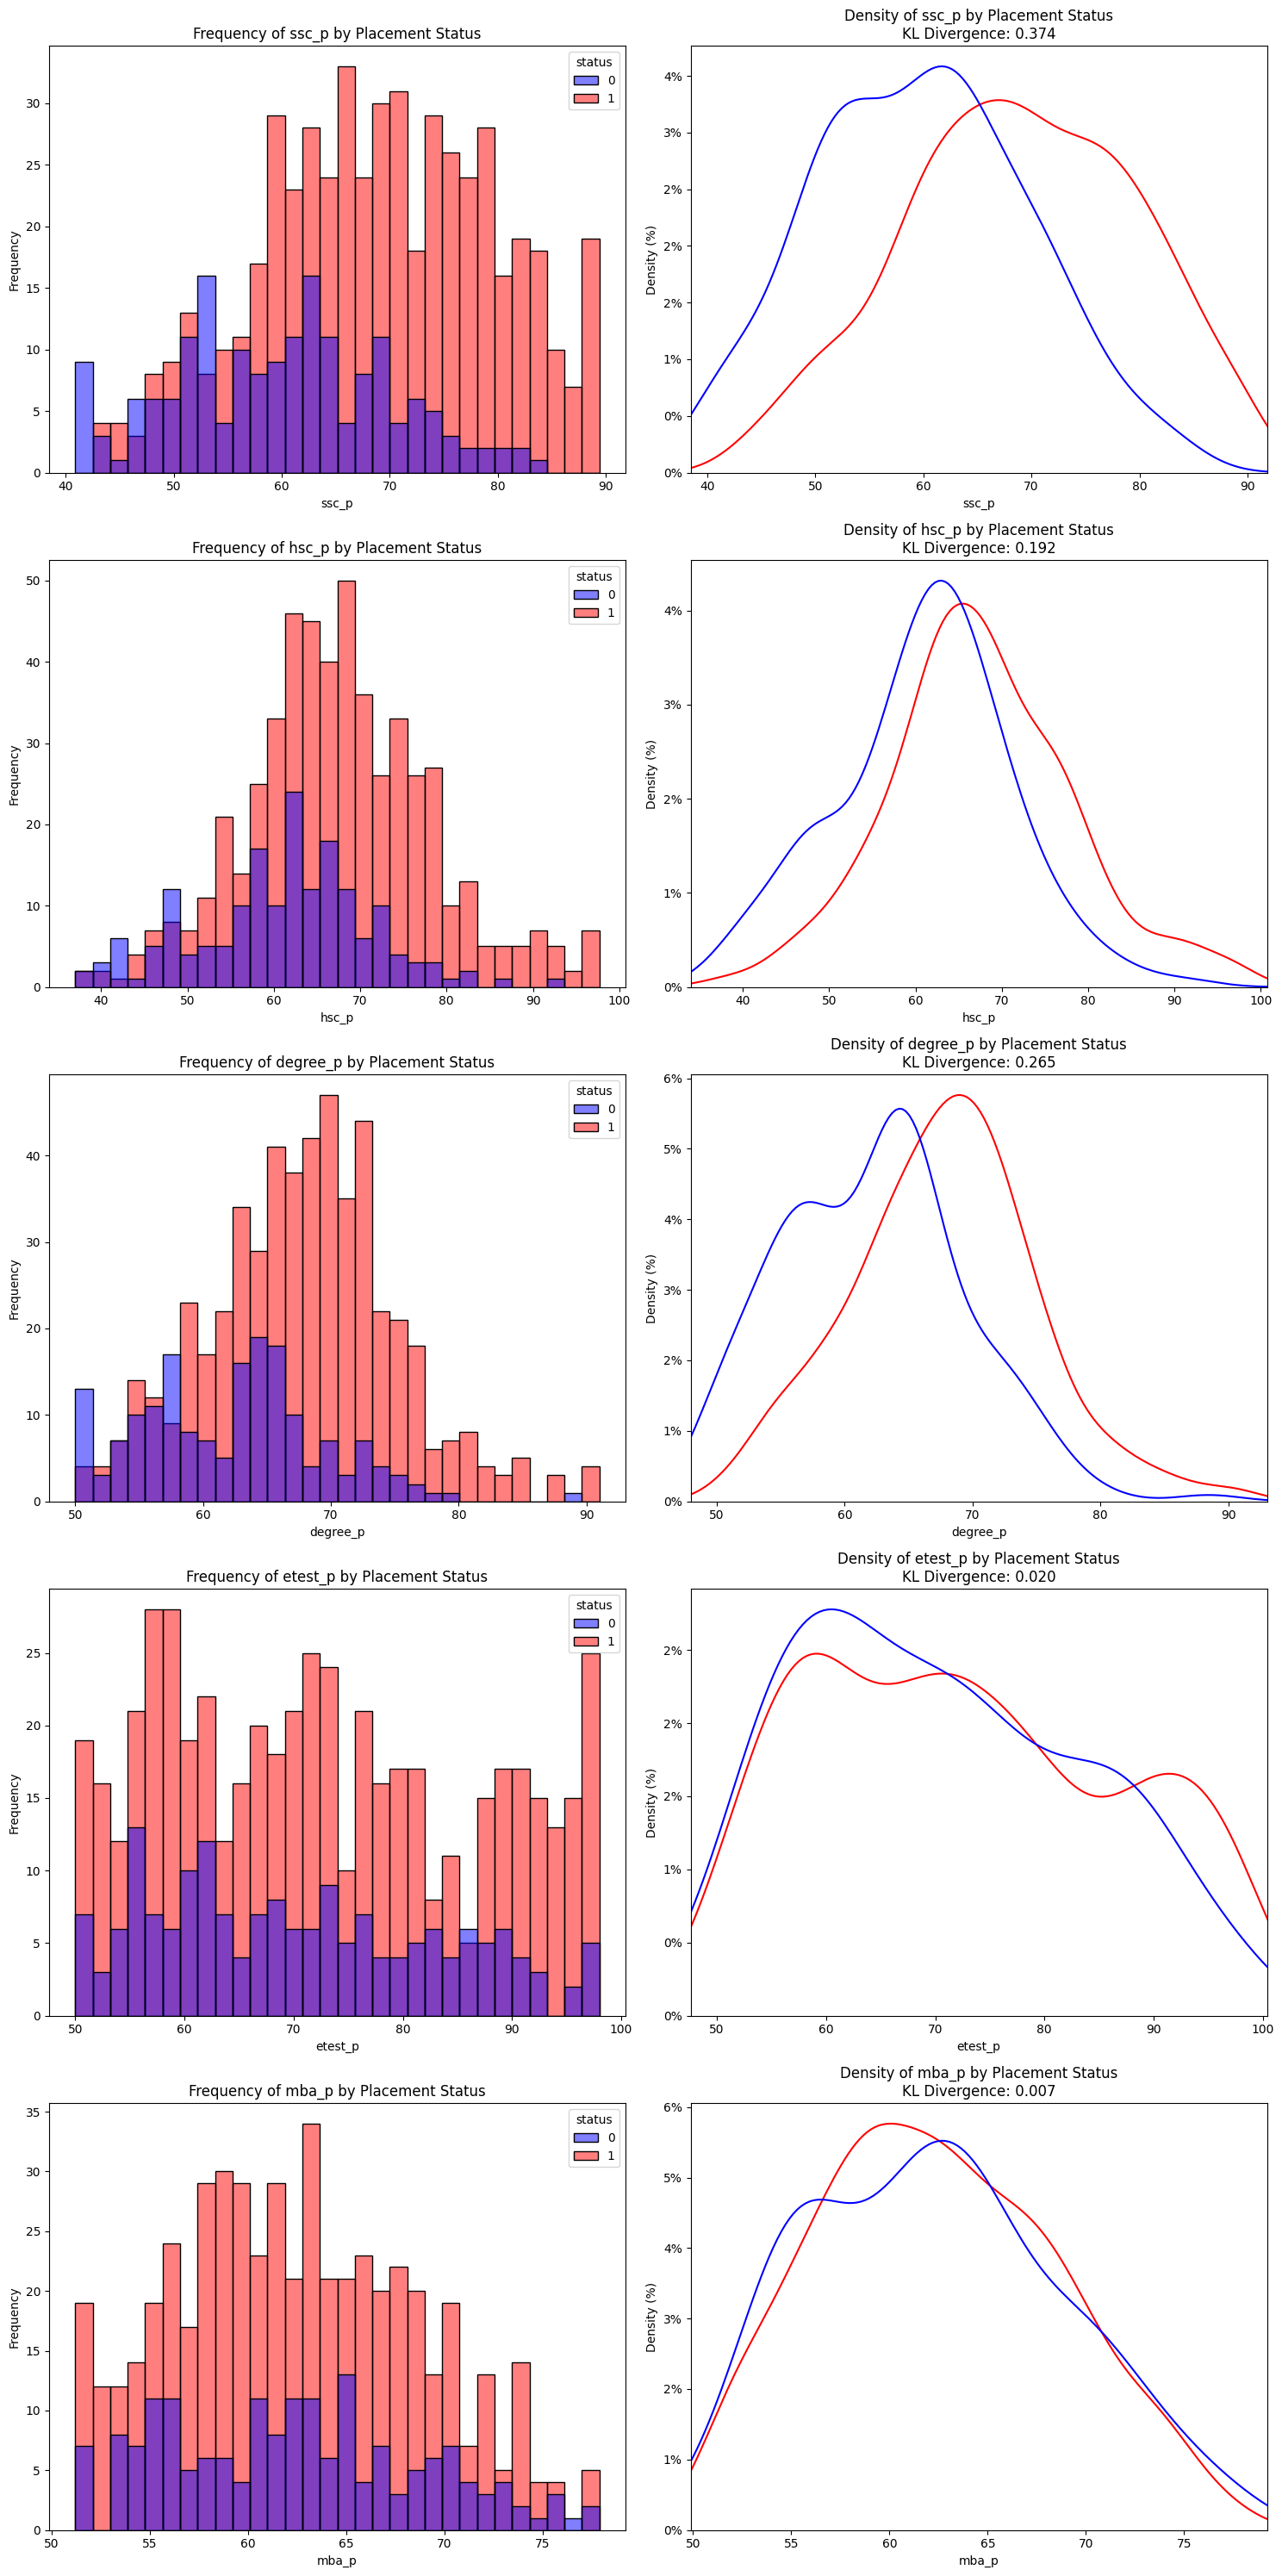

In [10]:
# Identify numerical columns excluding specific ones
numerical_cols = [col for col in df.select_dtypes(include=['int64', 'float64']).columns if col not in ['id', 'status', 'gender', 'workex']]

# Prepare long-form data for boxplot comparison
combined_df = pd.concat([
    placed_df[numerical_cols].melt(var_name='Feature', value_name='Value').assign(Status='Placed'),
    not_placed_df[numerical_cols].melt(var_name='Feature', value_name='Value').assign(Status='Not Placed')
])

# Generate boxplots for numerical features
fig, axes = plt.subplots(1, len(numerical_cols), figsize=(20, 8), sharey=False)
for ax, feature in zip(axes, numerical_cols):
    sns.boxplot(x='Status', y='Value', hue='Status', data=combined_df.query('Feature == @feature'),
                ax=ax, palette={'Placed': 'red', 'Not Placed': 'blue'}, legend=False)
    ax.set(title=f"Boxplot: {feature}", xlabel="Status", ylabel="Value")

plt.tight_layout()
plt.show()

# Create frequency and density plots with KL-divergence calculation
fig, axes = plt.subplots(len(numerical_cols), 2, figsize=(15, len(numerical_cols) * 6))
margin_factor = 0.05

for ax_pair, col in zip(axes, numerical_cols):
    sns.histplot(data=df, x=col, hue='status', kde=False, palette={1: 'red', 0: 'blue'}, bins=30, ax=ax_pair[0])
    ax_pair[0].set(title=f"Frequency of {col} by Placement Status", xlabel=col, ylabel="Frequency")

    for data, label, color in [(placed_df, 'Placed', 'red'), (not_placed_df, 'Not Placed', 'blue')]:
        sns.kdeplot(data=data, x=col, ax=ax_pair[1], color=color, label=f'{label} (Density)', common_norm=False)

    x_min, x_max = df[col].min(), df[col].max()
    x_range_extension = (x_max - x_min) * margin_factor

    for ax in ax_pair:
        ax.set_xlim(x_min - x_range_extension, x_max + x_range_extension)

    ax_pair[1].yaxis.set_major_formatter(plt.FuncFormatter(lambda y, _: f'{y:.0%}'))

    # KL-divergence calculation
    placed_kde = gaussian_kde(placed_df[col].dropna())
    not_placed_kde = gaussian_kde(not_placed_df[col].dropna())

    x_vals = np.linspace(x_min - x_range_extension, x_max + x_range_extension, 1000)

    placed_density = placed_kde(x_vals) / placed_kde(x_vals).sum()
    not_placed_density = not_placed_kde(x_vals) / not_placed_kde(x_vals).sum()

    kl_divergence = entropy(placed_density, not_placed_density)
    ax_pair[1].set(title=f"Density of {col} by Placement Status\nKL Divergence: {kl_divergence:.3f}", xlabel=col, ylabel="Density (%)")

plt.tight_layout()
plt.show()


### Analysis Conclusion

Through a detailed analysis of both categorical and numerical features, we identified several columns that contribute little to distinguishing between placed and not-placed students. Features with near-zero correlation, minimal occurrence differences, and overlapping distributions suggest limited predictive value.  

**Key findings include:**  
- **Low-correlation columns** such as `mba_p`, `degree_t_Sci&Tech`, and `ssc_b_Others` show weak relationships with placement status and may be removed to enhance model efficiency.  
- **Categorical features** like `workex`, `ssc_b_Others`, and `degree_t_Sci&Tech`, with occurrence differences of ≤ 2%, also appear to offer minimal predictive value.  
- **Numerical features** such as `etest_p` and `mba_p` exhibit nearly complete distribution overlap between placed and not-placed groups, further supporting their removal.  

By eliminating these less informative columns, the model can be streamlined, potentially improving both performance and interpretability while maintaining predictive accuracy.


## Data Models

### Intitialization

In [11]:
# Importing the libraries that will be used from the point onwards
import pandas as pd
import numpy as np
import optuna
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import accuracy_score, classification_report, mean_absolute_error, mean_squared_error, r2_score, confusion_matrix
from sklearn.metrics import pairwise_distances
from sklearn.metrics import roc_curve, auc

train_path = 'Cleaned/EncodedDataSet.csv'
train_df = pd.read_csv(train_path)

df = pd.DataFrame(train_df)

c:\Users\Alexa\AppData\Local\Programs\Python\Python313\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Random Forest

##### **Random Forest Model: Placement Prediction**

This section outlines training a **Random Forest** model to predict student placement (`status`), using **GridSearchCV** for hyperparameter tuning and performance evaluation.

##### **Feature Selection**
The model removes the following key features based on previous analysis and Kaggle performance:

- `"workex"`, `"ssc_b_Others"`, `"hsc_s_Science"`, `"degree_t_Others"`, `"degree_t_Sci&Tech"`, `"etest_p"`, `"mba_p"`

##### **Model Setup & Tuning**
- **Train-Test Split**: Data is split (75% train, 25% test) using stratification.  
- **GridSearchCV**: Optimizes key parameters:
    - `n_estimators`: (100, 200, 300)  
    - `max_depth`: (None, 10, 20, 30)  
    - Other parameters include `min_samples_split`, `bootstrap`, and `max_features`.  
- **Parallel Processing**: Uses 12 cores for faster training.

##### **Evaluation**
1. **Best Hyperparameters**: GridSearch identifies optimal settings.  
2. **Accuracy**: Assessed on the test set.  
3. **Classification Report**: Measures precision, recall, and F1-score.  
4. **Cross-Validation Score**: Ensures consistent performance across data splits.

\
By selecting relevant features and fine-tuning hyperparameters, the model achieves better accuracy and generalization for predicting student placements.

In [12]:
# ["status", "salary", "gender", "workex", "specialisation_Mkt&HR", "hsc_s_Science", "hsc_s_Commerce", "id"] -> seems to preform better in kaggle?
DataFrame = df.copy()
X = DataFrame.drop(["id","status", 'salary','workex', 'ssc_b_Others', 'hsc_s_Science', 'degree_t_Others', 'degree_t_Sci&Tech', 'etest_p', 'mba_p'], axis=1)

y = DataFrame["status"]

# Split up test and train data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, stratify=y)

# Define the parameter grid for GridSearchCV
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'bootstrap': [True, False],
    'max_features': ['sqrt', 'log2', None]
}

rf_model = RandomForestClassifier()

# Perform GridSearchCV using 12 cores
grid_search = GridSearchCV(estimator=rf_model, param_grid=param_grid, cv=5, scoring='accuracy', n_jobs=12, verbose=1)
grid_search.fit(X_train, y_train)

# Get the best parameters
best_params = grid_search.best_params_
print("Best hyperparameters found: ", best_params)

# Train the model using the best parameters found
best_rf_model = grid_search.best_estimator_
y_pred = best_rf_model.predict(X_test)

# Show model accuracy
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))

# Show cross-validation score
cv_scores = cross_val_score(best_rf_model, X, y, cv=5, n_jobs=12)
print("Cross-validation accuracy:", np.mean(cv_scores))

# Print classification report
print("Classification Report:\n", classification_report(y_test, y_pred, target_names=['Placed', 'Not Placed']))


Fitting 5 folds for each of 648 candidates, totalling 3240 fits
Best hyperparameters found:  {'bootstrap': True, 'max_depth': 30, 'max_features': 'log2', 'min_samples_leaf': 4, 'min_samples_split': 10, 'n_estimators': 200}
Accuracy: 0.7428571428571429
Classification Report:
               precision    recall  f1-score   support

           0       0.48      0.25      0.33        44
           1       0.78      0.91      0.84       131

    accuracy                           0.74       175
   macro avg       0.63      0.58      0.58       175
weighted avg       0.71      0.74      0.71       175

Cross-validation accuracy: 0.7728571428571428
Classification Report:
               precision    recall  f1-score   support

      Placed       0.48      0.25      0.33        44
  Not Placed       0.78      0.91      0.84       131

    accuracy                           0.74       175
   macro avg       0.63      0.58      0.58       175
weighted avg       0.71      0.74      0.71       175



#### Confusion Matrix - Random Forest

The purpose of this code is to create a side-by-side visualization of two important aspects of a machine learning model's performance: the confusion matrix and feature importance.

1. **Confusion Matrix Visualization**: 
   The confusion matrix helps evaluate the performance of a classification model by comparing the predicted labels (`y_pred`) against the actual labels (`y_test`). By visualizing the matrix as a heatmap, it becomes easier to assess how well the model classifies each class, as the matrix shows the true positives, false positives, false negatives, and true negatives.

2. **Feature Importance Visualization**: 
   This part visualizes the relative importance of each feature in the model's decision-making process. For a Random Forest model, the `feature_importances_` attribute indicates how much each feature contributes to the model's predictions. By displaying this in a bar plot, you can quickly identify which features are most influential in the model's predictions, aiding in model interpretation and potential feature selection.

From the current confusion matrix, we can conclude that the model is still heavily biased towards predicting "placed." This is evident because the number of records predicted as "placed" but actually belonging to the "non-placed" category is significantly higher than the number of "non-placed" records predicted as "placed."


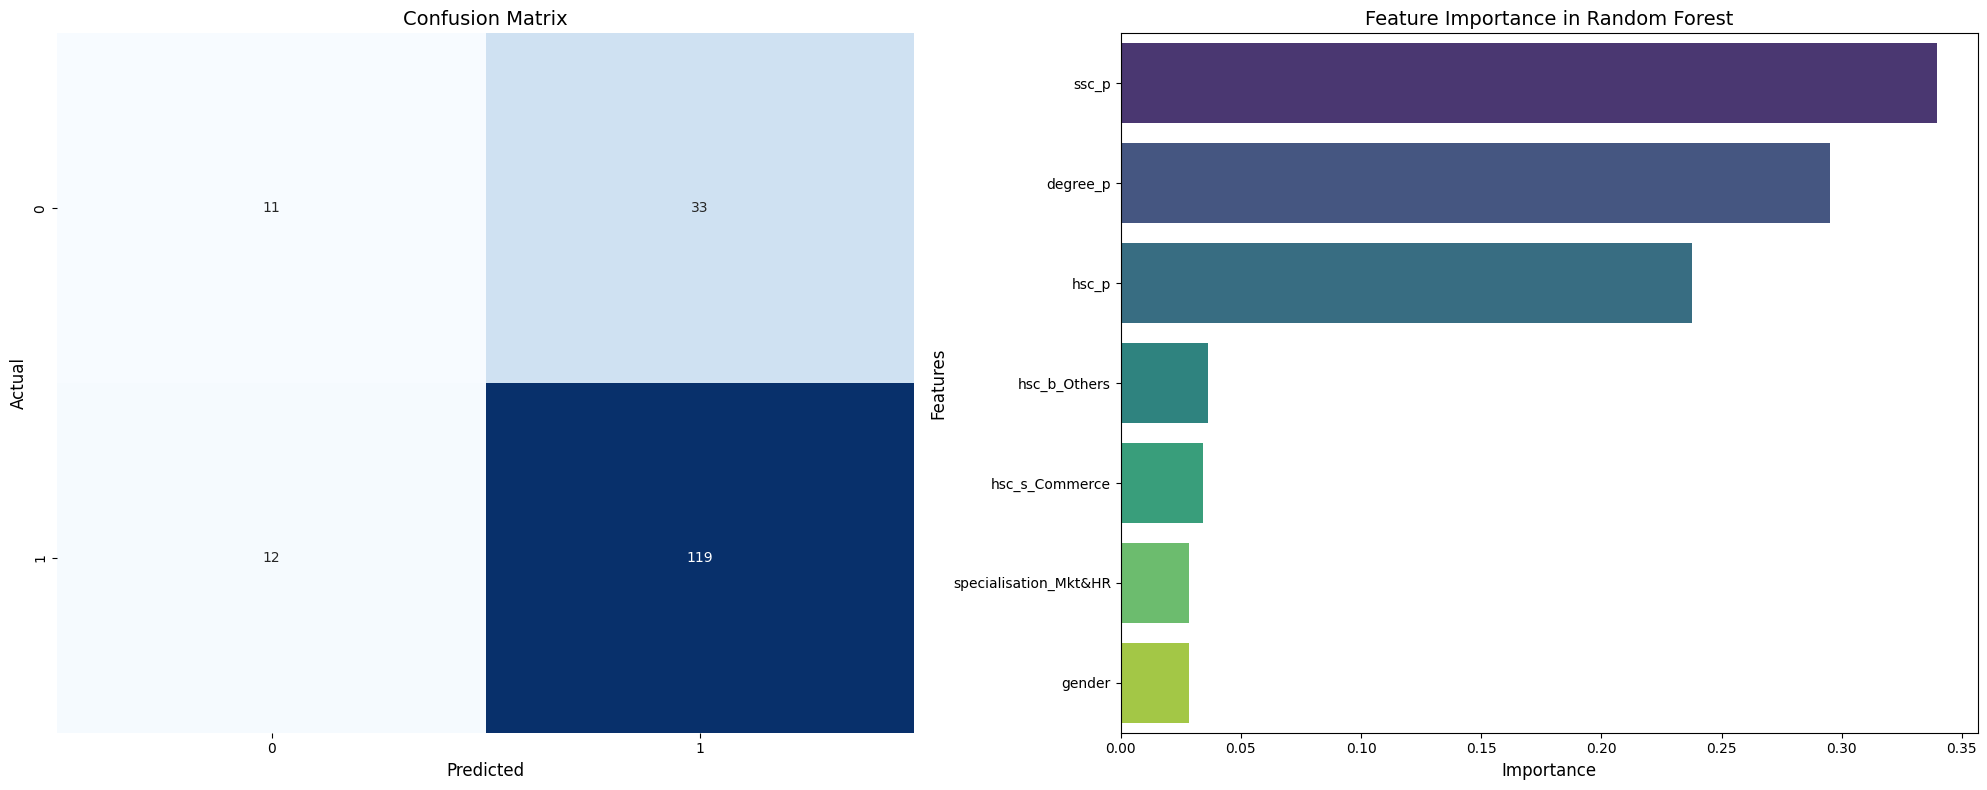

In [13]:
# Create a 1x2 subplot layout
fig, axes = plt.subplots(1, 2, figsize=(20, 8))

# Confusion matrix visualization
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt="d", cmap="Blues", cbar=False, ax=axes[0])
axes[0].set_title("Confusion Matrix", fontsize=14)
axes[0].set_xlabel("Predicted", fontsize=12)
axes[0].set_ylabel("Actual", fontsize=12)

# Feature importance visualization
feature_importances = pd.Series(best_rf_model.feature_importances_, index=X.columns).sort_values(ascending=False)
sns.barplot(x=feature_importances, y=feature_importances.index, palette="viridis", hue=feature_importances.index, ax=axes[1])
axes[1].set_title("Feature Importance in Random Forest", fontsize=14)
axes[1].set_xlabel("Importance", fontsize=12)
axes[1].set_ylabel("Features", fontsize=12)

# Adjust layout
plt.tight_layout()
plt.show()

### Logistic Regression Model

This section covers training a **Logistic Regression** model to predict student placement (`status`), a binary classification task.

##### **Data Preprocessing**
- **Missing Values**: Mean imputation for numerical data, mode imputation for categorical.
- **Feature Encoding**: **Label Encoding** for categorical features like `gender` and `workex`.

##### **Feature Scaling**
We use **Standard Scaling** to normalize the data and ensure equal feature contribution.

##### **Model Training & Evaluation**
- **Train-Test Split**: 75% for training, 25% for testing.
- **Cross-validation**: 5-fold cross-validation for stable performance.
- **Evaluation**: Accuracy, classification report (precision, recall, F1-score), and confusion matrix.


In [14]:
# Load the dataset
train_df = df.copy()

# Data Preprocessing
train_df.fillna(train_df.mean(), inplace=True)  # Handle missing values (numerical)
train_df.fillna(train_df.mode().iloc[0], inplace=True)  # Handle missing values (categorical)

# Encode categorical variables
label_encoder = LabelEncoder()
train_df['gender'] = label_encoder.fit_transform(train_df['gender'])  # Male: 0, Female: 1
train_df['workex'] = label_encoder.fit_transform(train_df['workex'])  # No: 0, Yes: 1
train_df = pd.get_dummies(train_df, drop_first=True)

# Split features (X) and target (y)
X = train_df.drop(['status', 'id', 'salary'], axis=1)
y = train_df['status']

# Feature Scaling
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Split data for training and testing
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.25, stratify=y, random_state=42)

# Train Logistic Regression Model
lr_model = LogisticRegression(random_state=42)
lr_model.fit(X_train, y_train)

# Evaluate the model
cv_scores = cross_val_score(lr_model, X_scaled, y, cv=5, scoring='accuracy')
print(f"Cross-Validation Accuracy: {cv_scores.mean() * 100:.2f}%")

# Predictions on the test set
y_pred = lr_model.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
print(f"Test Accuracy: {accuracy * 100:.2f}%")

print("\nClassification Report:")
print(classification_report(y_test, y_pred))


Cross-Validation Accuracy: 77.71%
Test Accuracy: 78.86%

Classification Report:
              precision    recall  f1-score   support

           0       0.65      0.34      0.45        44
           1       0.81      0.94      0.87       131

    accuracy                           0.79       175
   macro avg       0.73      0.64      0.66       175
weighted avg       0.77      0.79      0.76       175



#### Confusion Matrix - Logic regression model

 ##### **Confusion Matrix Analysis**  
- The model **over-predicts "Placed"** and struggles to correctly classify "Not Placed" candidates, leading to **high false positives (38)**.  
- The **false negatives (17)** indicate some placed candidates were misclassified, affecting overall accuracy.  

 ##### **Feature Importance Analysis**  
- **Academic performance (SSC, Degree, HSC percentages)** plays the biggest role in predicting placement.  
- **Secondary board type, stream, and specialization** also contribute but have a lower impact.  

 ##### **Overall Conclusion**  
The model favors predicting "Placed," indicating **a potential class imbalance or model bias**.  
Further **data balancing, feature engineering, and hyperparameter tuning** could improve performance. 



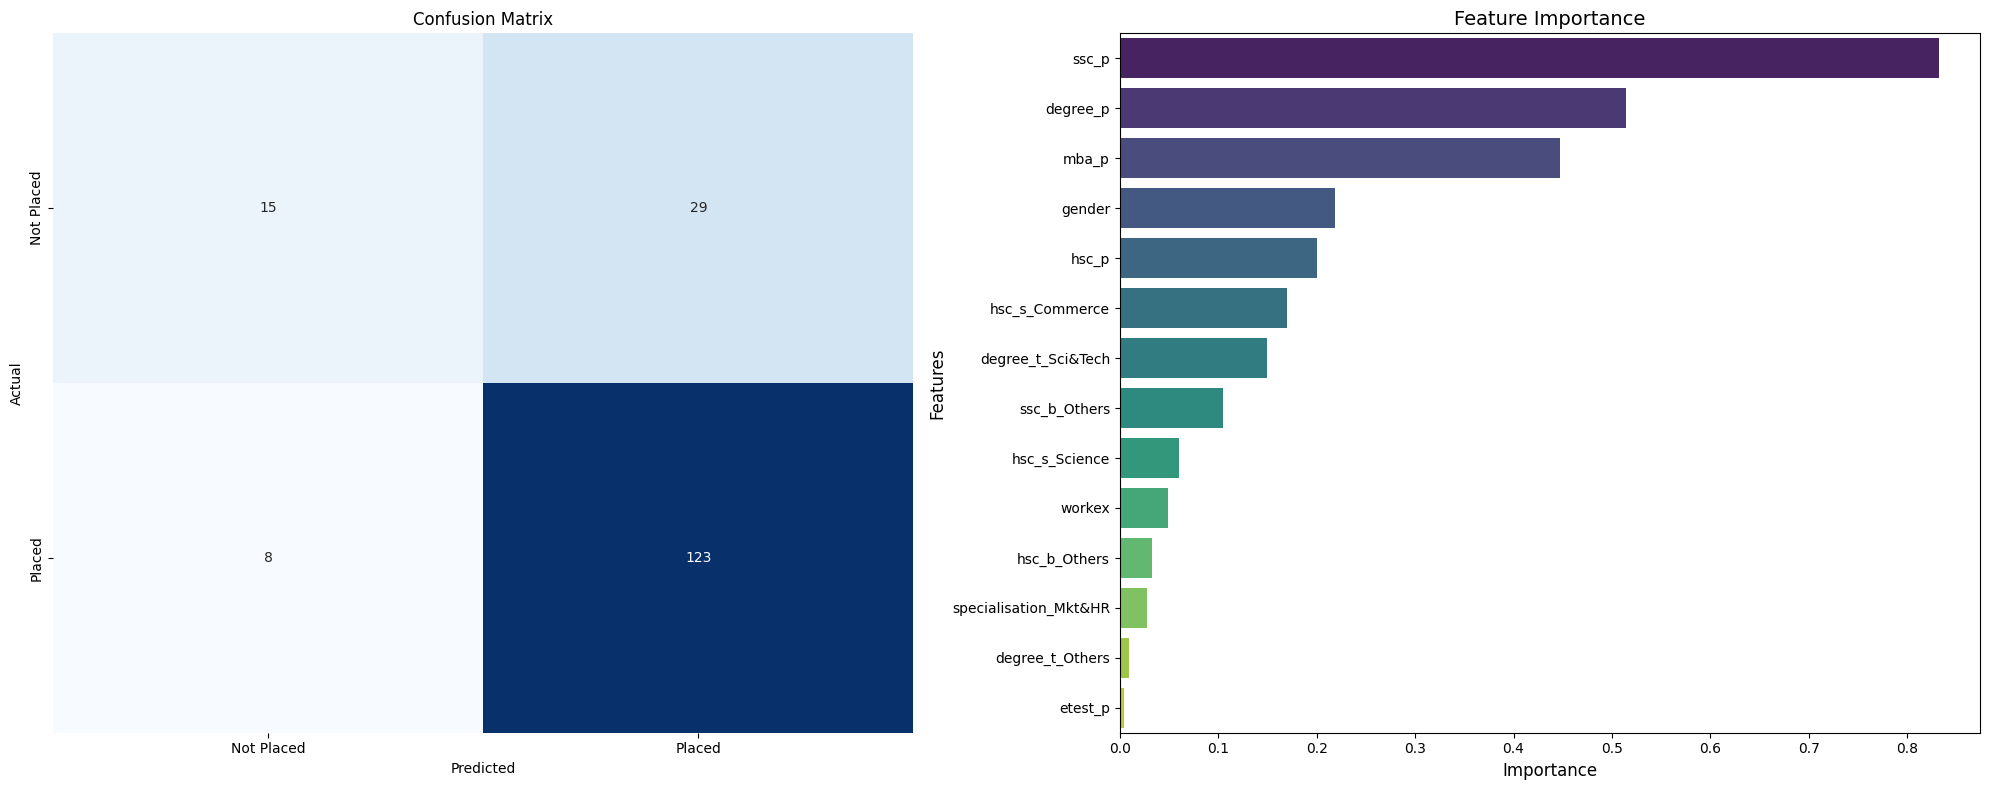

In [15]:
cm = confusion_matrix(y_test, y_pred)

# Feature Importance
feature_importance = np.abs(lr_model.coef_[0])
features = X.columns

# Create a figure with 2 subplots (1 for confusion matrix and 1 for feature importance)
fig, axes = plt.subplots(1, 2, figsize=(20, 8))

# Plot Confusion Matrix
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Not Placed', 'Placed'], 
            yticklabels=['Not Placed', 'Placed'], ax=axes[0], cbar=False)
axes[0].set_title("Confusion Matrix")
axes[0].set_xlabel("Predicted")
axes[0].set_ylabel("Actual")

# Plot Feature Importance (using pd.Series for better control)
feature_importances = pd.Series(feature_importance, index=features).sort_values(ascending=False)
sns.barplot(x=feature_importances, y=feature_importances.index, palette="viridis", hue=feature_importances.index, ax=axes[1])
axes[1].set_title("Feature Importance", fontsize=14)
axes[1].set_xlabel("Importance", fontsize=12)
axes[1].set_ylabel("Features", fontsize=12)

# Display the plot
plt.tight_layout()
plt.show()

#### ROC Curve and AUC

The ROC curve evaluates binary classification models by plotting the True Positive Rate (TPR) against the False Positive Rate (FPR) at various thresholds.

- **TPR**: Correctly identified positives.  
- **FPR**: Incorrectly identified negatives.

 ##### **The AUC quantifies the model's ability to distinguish classes:**  
- AUC of **0.5** means random performance.  
- AUC closer to **1** indicates better performance.

 ##### **Interpretation**
- The model achieves an **AUC of 0.76**, meaning it can distinguish between placed and not placed students **76% of the time**.  
- While **better than random guessing (AUC = 0.5)**, the model **is not highly accurate** and has room for improvement.

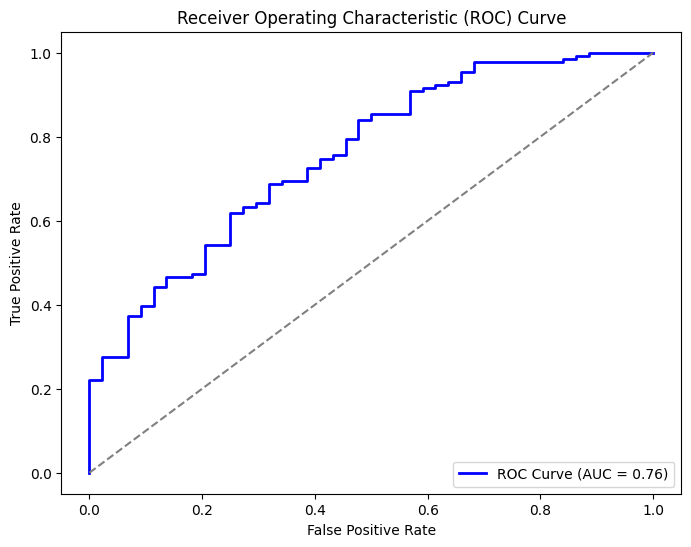

In [16]:
# ROC Curve
fpr, tpr, thresholds = roc_curve(y_test, lr_model.predict_proba(X_test)[:,1])
roc_auc = auc(fpr, tpr)

# Plot ROC Curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='b', lw=2, label=f'ROC Curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='lower right')
plt.show()


### Random Forest Regressor & Standard Regression

This code focuses on cleaning the dataset, optimizing a Random Forest model, and evaluating its performance. First, it creates a copy of the original dataset and removes irrelevant columns, such as `id`, `status`, and other categorical features that are not required for modeling. The feature columns are standardized using `StandardScaler` to ensure they are on the same scale, which is crucial for distance-based calculations.

Next, the code identifies duplicate entries by measuring the pairwise distances between feature vectors. If two entries have similar features (distance below a threshold) but different target values (in this case, `salary`), they are considered duplicates and removed to improve model quality.

After cleaning the dataset, the data is split into training and test sets, ensuring a 75%-25% split without stratification, as the target variable (`salary`) is continuous.

The core of the optimization process uses the Optuna library. It defines an objective function to optimize the hyperparameters of a RandomForestRegressor model. Optuna tries different combinations of hyperparameters (e.g., `n_estimators`, `max_depth`, `min_samples_split`, etc.) and selects the set that minimizes the negative mean squared error (MSE) through cross-validation.

Once the best hyperparameters are found, the model is retrained using these optimized settings and tested on the test set. The model's performance is evaluated with metrics like Mean Absolute Error (MAE), Mean Squared Error (MSE), Root Mean Squared Error (RMSE), and R² Score.

Finally, the stability of the model is checked using cross-validation, ensuring that the model generalizes well and doesn't overfit to the training data. The cross-validation results are presented as the Root Mean Squared Error (RMSE) to further assess the model's robustness.



In [17]:
# Load the dataset
data_frame = df.copy()
feature_columns = data_frame.drop(columns=["id", "status", "salary", "degree_t_Others", "hsc_b_Others", 
                                           "hsc_s_Science", "gender", "hsc_s_Commerce", "degree_t_Sci&Tech"])
target_column = data_frame["salary"]

# Standardizing features for distance calculation
feature_scaler = StandardScaler()
scaled_features = feature_scaler.fit_transform(feature_columns)

# Pairwise distance-based duplicate detection
distance_threshold = 0.1  # Adjust this value to change the data cleaning effect
feature_distances = pairwise_distances(scaled_features)
duplicate_indices = set()

for i in range(len(target_column)):
    for j in range(i + 1, len(target_column)):
        if target_column.iloc[i] != target_column.iloc[j] and feature_distances[i, j] < distance_threshold:
            duplicate_indices.add(i)
            duplicate_indices.add(j)

# Removing duplicate entries based on overlap
cleaned_features = feature_columns.drop(index=list(duplicate_indices))
cleaned_target = target_column.drop(index=list(duplicate_indices))

# Train-test split (No stratification since target is continuous)
train_features, test_features, train_target, test_target = train_test_split(cleaned_features, cleaned_target, test_size=0.25, random_state=42)

# Objective function for Optuna optimization
def optimize_rf_model(trial):
    hyperparameters = {
        "n_estimators": trial.suggest_int("n_estimators", 100, 500, step=50),
        "max_depth": trial.suggest_int("max_depth", 10, 50, step=10),
        "min_samples_split": trial.suggest_int("min_samples_split", 2, 10),
        "min_samples_leaf": trial.suggest_int("min_samples_leaf", 1, 4),
        "bootstrap": trial.suggest_categorical("bootstrap", [True, False]),
        "max_features": trial.suggest_categorical("max_features", ["sqrt", "log2", None]),
    }

    random_forest_model = RandomForestRegressor(**hyperparameters, n_jobs=-1)
    mse_scores = cross_val_score(random_forest_model, train_features, train_target, cv=5, scoring="neg_mean_squared_error")
    return -mse_scores.mean()  # Minimize MSE using Optuna

# Optimize hyperparameters using Optuna
study = optuna.create_study(direction="minimize")
study.optimize(optimize_rf_model, n_trials=10)

# Best hyperparameters after optimization
best_hyperparameters = study.best_params
print("Optimized Hyperparameters:", best_hyperparameters)

# Train the model using the best hyperparameters found
best_rf_model = RandomForestRegressor(**best_hyperparameters, n_jobs=-1)
best_rf_model.fit(train_features, train_target)

# Predictions on test set
predictions = best_rf_model.predict(test_features)

# Metrics for model performance
print("Mean Absolute Error:", mean_absolute_error(test_target, predictions))
print("Mean Squared Error:", mean_squared_error(test_target, predictions))
print("Root Mean Squared Error:", np.sqrt(mean_squared_error(test_target, predictions)))
print("R² Score:", r2_score(test_target, predictions))

# Cross-validation for stability of the model
cross_val_scores = cross_val_score(best_rf_model, cleaned_features, cleaned_target, cv=5, scoring="neg_mean_squared_error")
print("Cross-validation RMSE:", np.sqrt(-cross_val_scores.mean()))  

[I 2025-03-23 11:15:05,117] A new study created in memory with name: no-name-03c6c237-45de-4e0b-b43c-158dd8cb8e16
[I 2025-03-23 11:15:05,843] Trial 0 finished with value: 24635452417.988277 and parameters: {'n_estimators': 150, 'max_depth': 20, 'min_samples_split': 3, 'min_samples_leaf': 4, 'bootstrap': False, 'max_features': None}. Best is trial 0 with value: 24635452417.988277.
[I 2025-03-23 11:15:07,778] Trial 1 finished with value: 16139475284.891499 and parameters: {'n_estimators': 450, 'max_depth': 10, 'min_samples_split': 10, 'min_samples_leaf': 3, 'bootstrap': True, 'max_features': None}. Best is trial 1 with value: 16139475284.891499.
[I 2025-03-23 11:15:09,351] Trial 2 finished with value: 15743766587.020206 and parameters: {'n_estimators': 350, 'max_depth': 40, 'min_samples_split': 3, 'min_samples_leaf': 1, 'bootstrap': True, 'max_features': 'log2'}. Best is trial 2 with value: 15743766587.020206.
[I 2025-03-23 11:15:10,972] Trial 3 finished with value: 16236058019.098867 an

Optimized Hyperparameters: {'n_estimators': 350, 'max_depth': 40, 'min_samples_split': 3, 'min_samples_leaf': 1, 'bootstrap': True, 'max_features': 'log2'}
Mean Absolute Error: 105533.81917619401
Mean Squared Error: 17330454604.84288
Root Mean Squared Error: 131645.18451064924
R² Score: 0.24152499842272301
Cross-validation RMSE: 127300.79775624741


#### Predictive & Distributive Salary

This section visualizes the model's performance by comparing **actual vs predicted salaries** and analyzing the **residuals**.

##### **1. Scatter Plot of Actual vs Predicted Salaries**
A scatter plot compares **actual** (true) and **predicted salaries**. The **x-axis** shows actual values, the **y-axis** shows predicted values, and the **red line** represents the "perfect fit." Points close to the line indicate accurate predictions.

##### **2. Residual Plot**
The residual plot shows the differences between actual and predicted values. 
- Residuals should be randomly distributed around zero, indicating a good model fit.
- The **red dashed line** shows zero error, and **gray dashed lines** show the standard deviation of residuals.

These plots help assess model performance and identify potential issues like underfitting or overfitting.

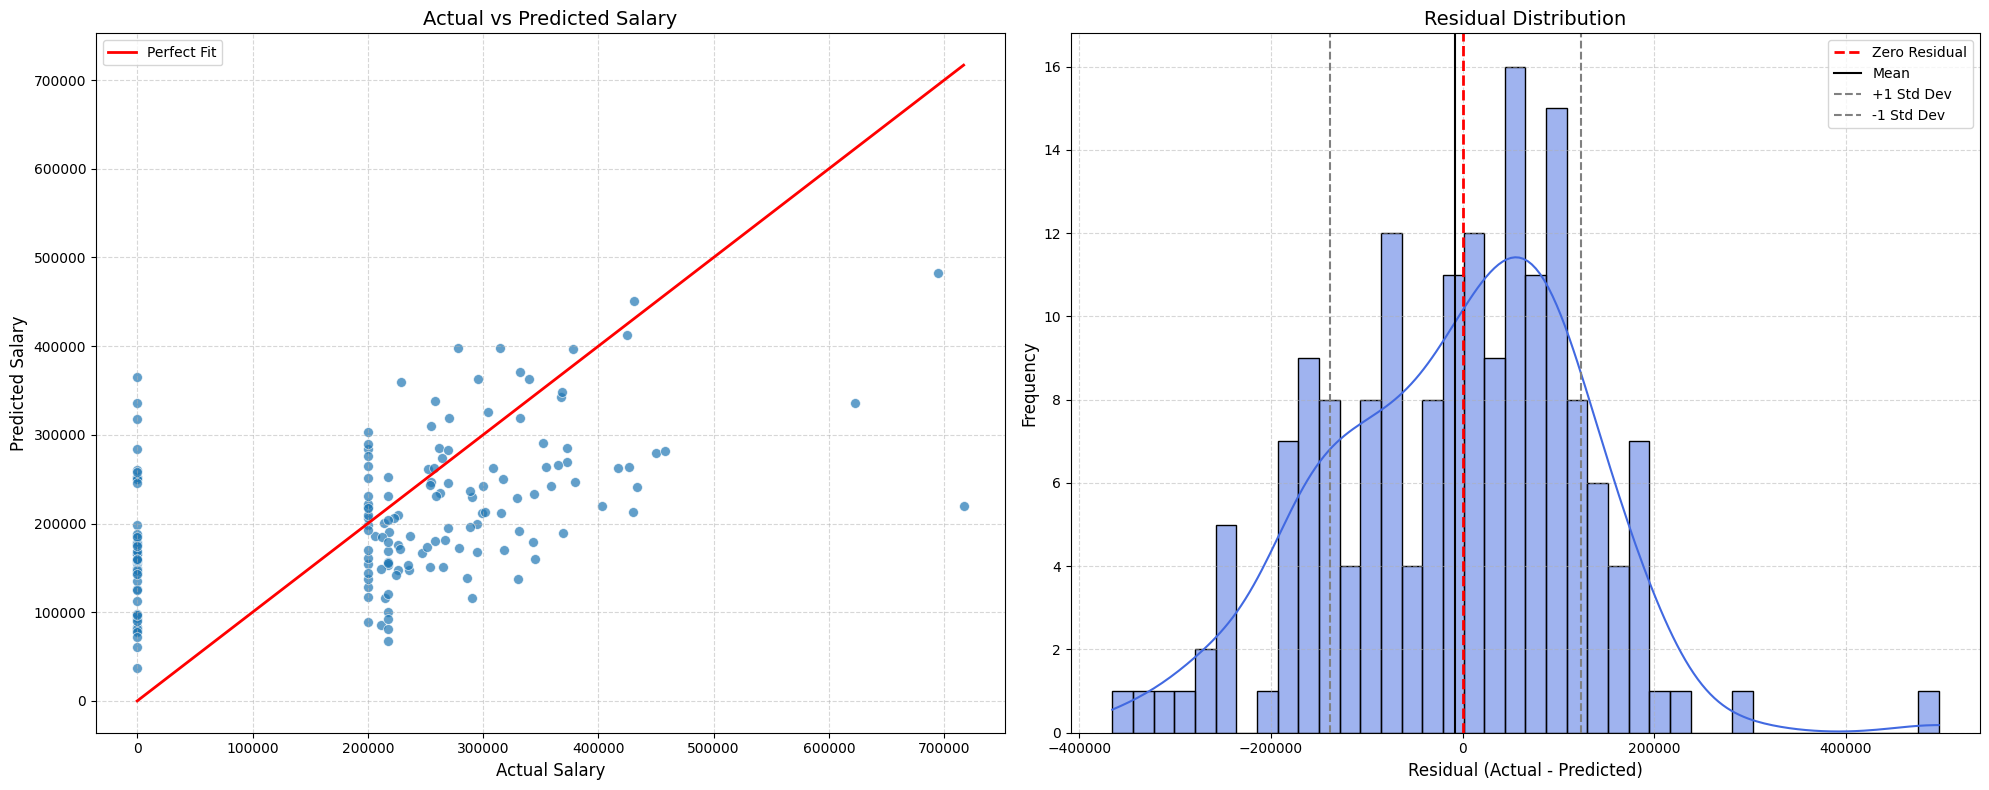

In [18]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.metrics import mean_squared_error

# Create a 1x2 subplot layout
fig, axes = plt.subplots(1, 2, figsize=(20, 8))

# Scatter plot of actual vs predicted salaries
sns.scatterplot(x=test_target, y=predictions, alpha=0.7, s=50, ax=axes[0])
axes[0].plot([test_target.min(), test_target.max()], [test_target.min(), test_target.max()], 'r-', linewidth=2, label="Perfect Fit")
axes[0].set_xlabel("Actual Salary", fontsize=12)
axes[0].set_ylabel("Predicted Salary", fontsize=12)
axes[0].set_title("Actual vs Predicted Salary", fontsize=14)
axes[0].legend()
axes[0].grid(True, linestyle='--', alpha=0.5)

# Residual plot
residuals = test_target - predictions
sns.histplot(residuals, bins=40, kde=True, color="royalblue", ax=axes[1])
axes[1].axvline(0, color='red', linestyle='--', linewidth=2, label="Zero Residual")

# Mean and Std Dev lines
mean_residual = np.mean(residuals)
std_residual = np.std(residuals)
axes[1].axvline(mean_residual, color='black', linestyle='-', label="Mean")
axes[1].axvline(mean_residual + std_residual, color='gray', linestyle='--', label="+1 Std Dev")
axes[1].axvline(mean_residual - std_residual, color='gray', linestyle='--', label="-1 Std Dev")

axes[1].set_xlabel("Residual (Actual - Predicted)", fontsize=12)
axes[1].set_ylabel("Frequency", fontsize=12)
axes[1].set_title("Residual Distribution", fontsize=14)
axes[1].legend()
axes[1].grid(True, linestyle='--', alpha=0.5)

# Adjust layout and display the figure
plt.tight_layout()
plt.show()


### Model predictions & Export


#### Initialization

This code preprocesses the test data to match the format of the training data, makes predictions using a trained Random Forest model, and exports the results. \
The test data undergoes encoding for categorical variables and one-hot encoding for others. To ensure consistency with the training data, the test features are reindexed to align with the model's expected input. \
\
After making predictions, the results are saved alongside the original `id` values into a CSV file for easy analysis. This ensures that the model can evaluate new data in the same way it was trained.
The Random forest file is also the file that is uploaded onto the `ThomasMore ML Challenge 2025` challenge on Kaggle.

In [19]:
# Load the test dataset
test_df = pd.read_csv('DataSets/test_campusrecruit.csv')

# Store 'id' for the output
ids = test_df['id']

# Encode categorical variables in the test dataset
test_df['gender'] = test_df['gender'].map({'M': 1, 'F': 0})
test_df['workex'] = test_df['workex'].map({'Yes': 1, 'No': 0})
test_df = pd.get_dummies(test_df, drop_first=True)

# Align test dataset with training features
X_test_final = test_df.drop(['id'], axis=1)

# Ensure test data matches training data columns
X_test_final = X_test_final.reindex(columns=X.columns, fill_value=0)

#### Exports

##### Random forest

In [20]:
# Align test features with training features
test_df = scaler.transform(X_test_final)

# Train the model and make predictions
rf_model.fit(X_train, y_train)
predictions = ['Placed' if pred == 1 else 'Not Placed' for pred in rf_model.predict(test_df)]

# Save predictions to CSV (using the original 'id' column)
output_df = pd.DataFrame({'id': ids, 'status': predictions})
output_df.to_csv('./Cleaned/output.csv', index=False)
print("Predictions exported to Cleaned/output.csv")

# Display the first few rows of the results
output_df.head()


Predictions exported to Cleaned/output.csv


id      status
0  655      Placed
1  910      Placed
2  447      Placed
3  324  Not Placed
4  178      Placed

##### logistic Regression

In [21]:
# Scale the test data using the trained scaler
X_test_final_scaled = scaler.transform(X_test_final)

# Make predictions
predictions = lr_model.predict(X_test_final_scaled)

# Convert predictions to human-readable format
predictions = ['Placed' if pred == 1 else 'Not Placed' for pred in predictions]

# Create the output DataFrame
results_df = pd.DataFrame({
    'id': ids,
    'status': predictions
})

# Export predictions to CSV
results_df.to_csv('./Cleaned/output_logistic.csv', index=False)
print("Predictions exported to Cleaned/output_logistic.csv")

# Display the first few rows of the output DataFrame
results_df.head()

Predictions exported to Cleaned/output_logistic.csv


id      status
0  655      Placed
1  910      Placed
2  447      Placed
3  324  Not Placed
4  178      Placed

##### salary prediction

In [22]:
# Train a RandomForestRegressor model for 'salary' prediction
# Ensure that the salary feature is also removed from training data
y_salary = df["salary"]
X_without_salary = df.drop(columns=["id", "status", "salary"])  # Exclude 'id', 'status', and 'salary' from training

# Train RandomForestRegressor for salary prediction
rf_salary_model = RandomForestRegressor(random_state=42)
rf_salary_model.fit(X_without_salary, y_salary)

# Predict salary on the test set
salary_predictions = rf_salary_model.predict(test_df)

# Prepare the output DataFrame with 'id' and 'predicted_salary' only
output_df_salary_only = pd.DataFrame({
    'id': ids,
    'predicted_salary': salary_predictions
})

# Save predictions to CSV (including only id and predicted salary)
output_df_salary_only.to_csv('./Cleaned/output_salary.csv', index=False)
print("Predictions exported to Cleaned/output_salary.csv")

# Display the first few rows of the results
output_df_salary_only.head()


Predictions exported to Cleaned/output_salary.csv


c:\Users\Alexa\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


id  predicted_salary
0  655          88044.17
1  910          93506.93
2  447         117091.57
3  324         110449.51
4  178          93803.99

## Conclusion

In this document, we developed and evaluated a predictive model for a person's recruitment status. After cleaning/encoding the data, optimizing a Random Forest model using GridSearchCV, creating a logistic regression mode, and removing the columns identified during our EDA, we compared their performance against a baseline model (DummyClassifier) that simply predicts the most frequent class.

The comparison reinforced the fact that the Random Forest model, and logistic regression outperformed the baseline model, though only slightly, in terms of both accuracy and cross-validation scores. This improvement demonstrates that our optimized models are more effective and provide more reliable predictions

Fitting 5 folds for each of 648 candidates, totalling 3240 fits
Fitting 5 folds for each of 648 candidates, totalling 3240 fits
Fitting 5 folds for each of 648 candidates, totalling 3240 fits
Fitting 5 folds for each of 648 candidates, totalling 3240 fits
Fitting 5 folds for each of 648 candidates, totalling 3240 fits


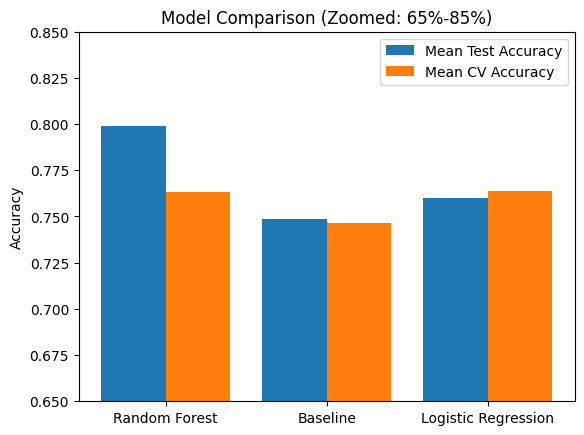

In [23]:
# Testing the improvements made to the model
from sklearn.dummy import DummyClassifier

# Preprocess the data
X = df.drop(["id", "status", 'salary', 'workex', 'ssc_b_Others', 'hsc_s_Science', 
             'degree_t_Others', 'degree_t_Sci&Tech', 'etest_p', 'mba_p'], axis=1)
y = df["status"]

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, stratify=y)

# Scale the data for Logistic Regression and Random Forest
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Define the Random Forest parameter grid
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'bootstrap': [True, False],
    'max_features': ['sqrt', 'log2', None]
}

# Optimized Random Forest Model
rf_accuracies = []
rf_cv_scores_list = []
rf_model = RandomForestClassifier()

for _ in range(5):
    grid_search = GridSearchCV(estimator=rf_model, param_grid=param_grid, cv=5, scoring='accuracy', n_jobs=-1, verbose=1)
    grid_search.fit(X_train_scaled, y_train)

    best_rf_model = grid_search.best_estimator_
    y_pred_rf = best_rf_model.predict(X_test_scaled)

    rf_accuracies.append(accuracy_score(y_test, y_pred_rf))
    rf_cv_scores = cross_val_score(best_rf_model, X_train_scaled, y_train, cv=5, n_jobs=-1)
    rf_cv_scores_list.append(np.mean(rf_cv_scores))

# Baseline (Most Frequent) Model
dummy_accuracies = []
dummy_cv_scores_list = []

for _ in range(5):
    dummy_model = DummyClassifier(strategy='most_frequent')
    dummy_model.fit(X_train, y_train)

    y_pred_dummy = dummy_model.predict(X_test)

    dummy_accuracies.append(accuracy_score(y_test, y_pred_dummy))
    dummy_cv_scores = cross_val_score(dummy_model, X_train, y_train, cv=5, n_jobs=-1)
    dummy_cv_scores_list.append(np.mean(dummy_cv_scores))

# Logistic Regression Model
lr_accuracies = []
lr_cv_scores_list = []

# Use a higher max_iter for Logistic Regression to avoid convergence warning
lr_model = LogisticRegression(random_state=42, max_iter=1000)
for _ in range(5):
    lr_model.fit(X_train_scaled, y_train)

    y_pred_lr = lr_model.predict(X_test_scaled)

    lr_accuracies.append(accuracy_score(y_test, y_pred_lr))
    lr_cv_scores = cross_val_score(lr_model, X_train_scaled, y_train, cv=5, n_jobs=-1)
    lr_cv_scores_list.append(np.mean(lr_cv_scores))

# Visualization of results
labels = ['Random Forest', 'Baseline', 'Logistic Regression']
accuracies = [np.mean(rf_accuracies), np.mean(dummy_accuracies), np.mean(lr_accuracies)]
cv_accuracies = [np.mean(rf_cv_scores_list), np.mean(dummy_cv_scores_list), np.mean(lr_cv_scores_list)]

x = np.arange(len(labels))

plt.bar(x - 0.2, accuracies, 0.4, label='Mean Test Accuracy')
plt.bar(x + 0.2, cv_accuracies, 0.4, label='Mean CV Accuracy')

plt.ylabel('Accuracy')
plt.title('Model Comparison (Zoomed: 65%-85%)')
plt.xticks(x, labels)
plt.ylim(0.65, 0.85)
plt.legend()
plt.show()

# Gen-AI Policy

AI-generated code can enhance productivity and streamline both analysis and the coding process. However, it also poses certain risks. In the context of this document, these risks include:

- **Reduction in critical thinking**
- **Generation of biased outputs**
- **Producing irrelevant or incorrect code**
- **Degradation of code comprehension**

While AI-generated code was extensively used in the creation of this report, we have taken steps to mitigate these risks wherever possible.



## Query Documentation

Below are the majority of the AI queries used during the creation of this report, categorized by section. For clarity, the actual code context given to the AI has been omitted. All AI-generated code was manually reviewed and/or edited by the team, so our code doesn't solely result from these queries.
Also note that different AI services, which don't require queries like QuillBot, were used to check spelling and grammar.

### Data Cleaning & Encoding
- "This is my dataset. Can you clean/encode it how you see fit. Make sure that all salaries for "Placed" records which have a value of 0.0 are set to the median of all values."

### Exploratory Data Analysis (EDA)

**Placed vs Not placed - Data Bias**
- "Here is an example of my dataset, make a graph displaying the total amount of placed and non placed records, make sure to put the amount of each ontop of the respective bar"

**Placement vs. Column Correlation**
- "Here are the columns of my encoded dataset. Can you make a graph showing the corrolation of each column with the "status" column."

**Categorical Occurrences: Placed vs. Not Placed**
- "Here is an example from my dataset. Can you graph the frequency of each categorical column based on their retrospective placed on not placed status."
- "Can you turn this into 2 septerate graphs. Make sure the values in each are shown based on 100% of all records of their retrospective status, so its easier to see the trend."
- "Can you add a line to both graphs displaying the total percentage bool value of each column. e.g. there are 100 gender records, 60% are male, then the percentage would be 60 since the males are true."
- "Add the percentage number to the points on each bar in the graph, and a set of percentage points to the right of the graph for clarity."

**Categorical Occurrence Differential**
- "Here are my graphs. Can you make another graph showing the differences between placed and non placed data in a percentage?"

**Numerical Data Distribution**
- "Here is an example of my dataset. Can you create a boxplot for each numerical column in the dataset."
- "Can you combine all of these graphs into one figure?"
- "Can you also create a graph for the frequence of each of a bin of each value for the placed column."
- "Due to the disparity in representation this isnt totally readable. Can you also make a second graph for each column showing frequency accounting for the total amount of records for each."
- "Can you combine these graphs into a figure 2 graphs wide?"
- "Alot of these graphs have alot of overlap. Can you somehow show the amount of overlap in a numeric value on these graphs."

### Data Model

**Random Forest Model**
- "This is my dataset. Can you create a randomforest model based on it?"
- "Is there any way the parameters could be optimized somehow?"

    **Confusion Matrix**
    - "Can i evaluate my model somehow?"

**Logical Regression Model**
- "What is the best to create a model like random forests"
- "Can u explain what a logical regression model is"
- "What are the key differences between a random forest and logical regression"

    **Confusion Matrix - Logic regression model**
    - "help me create a confusion matrix and a importance graph"
    
    **ROC Curve and AUC**
    - "Is there another way to show Logical regression other then confusion matrix"
    - "How can I code that graph"
    - "Can u explain how to read that graph and what it means"

**Random Forest Regressor & Standard Regression**
- "Can i have the model automatically find the best weight"

    **Predictive & Distributive Salary**
    - "Can i evaluate my model somehow?"
    - "these are my results, are these resuslts good? how should i visualise if it's good or not"
    - "for the actual vs predictaed salary graph image, isn't it bad that theres like a lot of values at the start far way from the line"

**Model predictions & Export**
- "Here is my training dataset, test dataset and model code. While automatically keeping into account the differences in columns between the test data and model data due to dropping tables, create an export for the prediction for the test data"
- "Can you limit the columns to the id, and status. Make sure the id is the same as in the respective records in the test dataset"

### Conclusion

**Model Comparison**
- "Here is my current best model. I want to make a graph showing it compaired to a baseline default model. Can you create this in a bar graph for me?"
- "Can you zoom into the top 65-85% to excentuate the difference"
- "Just one test is not enough to show to conclusively show mine is better then baseline. Can you make it so it runs multiple of each and takes the median?"
- "Can you add my logistic regression to this comparison graph?"
